<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/Analysis_of_EPI2ME_16S_CSV_Output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Analysis of EPI2ME 16S CSV Output</h1>

The EPI2ME 16S (and WIMP) analyses allow the download of a summary table of the results. However this table does not contain full lineage information and so it is not immediately useful to create the Sankey tree diagrams that EPI2ME displays in its web interface.

The following short code fragments, demonstrate how to decorate the EPI2ME data table and aggregate the read counts. 

An example 16S report can be found [here](https://epi2me.nanoporetech.com/workflow_instance/242318?token=6FF8C4B6-D055-11EA-A7B7-23477BC332F9).

To use the EPI2ME outputs for this run enable the "use_sample_data" checkbox below: this will download the corresponding CSV output file.

Alternatively you can upload your own data using the filebrowser to the left-hand side of this page:

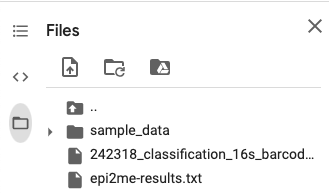

To upload your own EPI2ME results file first right-click and select `Upload`:

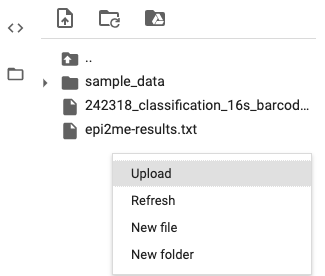

and then right-click on the file an click `Copy path`:

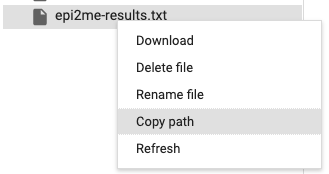

Paste the filepath into the `epi2me_results_file` text box below (remembering to uncheck the `use_sample_data` checkbox).

## Data Input

After entering your inputs below, select `Runtime > Run all` from the
menu at the top of the page. 

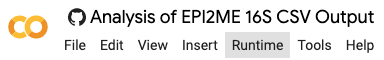

In [ ]:
#@markdown Please select to use the sample data, or enter your own.
import os
use_sample_data = True #@param {type:"boolean"}
epi2me_results_file = "" #@param {type:"string"}

if use_sample_data:
    print("Using sample data")
    bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
    domain = "s3-eu-west-1.amazonaws.com"
    site = "https://{}.{}".format(bucket, domain)
    
    epi2me_results_file = "242318_classification_16s_barcode-v1.csv"
    
    !echo "Downloading sample data"
    !wget -q $site/misc/242318_classification_16s_barcode-v1.csv \
        && echo "Download complete" || echo "Download failed"
    !echo
else:
    print("Using user provided file: {}".format(epi2me_results_file))
if not os.path.isfile(epi2me_results_file):
    print("File does not exist")
print("\nFirst 10 lines of file:")
!head $epi2me_results_file || echo "File not readable"

If you wish to understand  what the
notebook is doing read through the following section or simply skip to
the **Analysis** section.

### Workflow

The following section downloads some necessary pieces of software to decorate the EPI2ME results file with lineage information. There is no need to read through this section if you are not interested in how the code operates.

In order to decorate the file with lineage information we will use the [taxonkit](https://bioinf.shenwei.me/taxonkit/) tool. The codebox below will download this tool and also `csvkit` which we will use to convert the EPI2ME file from a comma-separated file to a tab-seperated file (which taxonkit requires)

In [2]:
!pip install csvkit
!wget https://github.com/shenwei356/taxonkit/releases/download/v0.6.0/taxonkit_linux_amd64.tar.gz
!tar -xzvf taxonkit_linux_amd64.tar.gz

     |████████████████████████████████| 3.8MB 4.4MB/s 
     |████████████████████████████████| 102kB 9.4MB/s 
     |████████████████████████████████| 163kB 44.4MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
  Created wheel for csvkit: filename=csvkit-1.0.5-cp36-none-any.whl size=41629 sha256=32ee97344ffd41a79dd57227295511e82629636d7cce4cb50ce5b6d580e4f7e5
  Stored in directory: /root/.cache/pip/wheels/3d/ab/50/b046530c9276b2f84b722e90ead08119a580d5636561cfe2a6
  Created wheel for agate-excel: filename=agate_excel-0.2.3-py2.py3-none-any.whl size=6270 sha256=8ccf2801fb074ac60e50de6201376c3444f3268826d41abdff33586fe4e486f3
  Stored in directory: /root/.cache/pip/wheels/8a/2f/99/dbf1c6af14192030927240678c0d2176b479dcc44b51a3a6d0
  Created wheel for agate-dbf: filename=agate_dbf-0.2.2-py2.py3-none-any.whl size=3512 sha256=22cd7cafc5e0b49fc176550ebe88bdc697e22252c9a6486d793972d5762c916a
  Stored in directory: /root/.cache/pip

Taxonkit requires the NCBI taxonomy database to function, let's download and decompress that:

In [3]:
!mkdir taxdump
%cd taxdump
!wget http://ftp.ncbi.nih.gov/pub/taxonomy/taxdump.tar.gz
!tar -xzvf taxdump.tar.gz
%cd ..

/content/taxdump
--2020-08-13 10:04:01--  http://ftp.ncbi.nih.gov/pub/taxonomy/taxdump.tar.gz
Resolving ftp.ncbi.nih.gov (ftp.ncbi.nih.gov)... 130.14.250.12, 2607:f220:41e:250::11, 2607:f220:41e:250::13, ...
Connecting to ftp.ncbi.nih.gov (ftp.ncbi.nih.gov)|130.14.250.12|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ftp.ncbi.nih.gov/pub/taxonomy/taxdump.tar.gz [following]
--2020-08-13 10:04:02--  https://ftp.ncbi.nih.gov/pub/taxonomy/taxdump.tar.gz
Connecting to ftp.ncbi.nih.gov (ftp.ncbi.nih.gov)|130.14.250.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52933058 (50M) [application/x-gzip]
Saving to: ‘taxdump.tar.gz’

taxdump.tar.gz      100%[===================>]  50.48M  31.5MB/s    in 1.6s    

2020-08-13 10:04:04 (31.5 MB/s) - ‘taxdump.tar.gz’ saved [52933058/52933058]

citations.dmp
delnodes.dmp
division.dmp
gencode.dmp
merged.dmp
names.dmp
nodes.dmp
gc.prt
readme.txt
/content


We now have all we need to get going:
- the EPI2ME results
- taxonkit
- The NCBI taxonomy

Let's first write a code function to read in and perform several conversions on the EPI2ME file

In [4]:
import pandas as pd
def parse_epi2me(fname):
    fnametsv = fname + '.tsv'
    print("Converting to TSV")
    !csvformat -T $fname > $fnametsv
    print("Running lineage")
    !./taxonkit lineage --data-dir taxdump $fnametsv -i 5 > epi2me2lineage.tmp
    print("Running reformat")
    !./taxonkit reformat --data-dir taxdump -i 12 epi2me2lineage.tmp > epi2me2lineage
    print("Munging data")
    epi2me = pd.read_csv("epi2me2lineage", sep='\t')
    # rename some columns so they don't clash with the lineage info
    epi2me.columns = epi2me.columns[0:len(epi2me.columns)-2].to_list() + ['_lineage', 'lineage']
    epi2me = epi2me.rename(columns={'species': 'species_name', 'genus':'genus_name'})
    # extract the lineage info into its on columns in the table
    lineage = epi2me['lineage'].str.split(";", expand=True)
    lineage.columns = ['kingdom', 'phylum', 'class', 'order', 'family','genus', 'species']
    epi2me = pd.concat((epi2me, lineage), axis=1)
    return epi2me

And run the function on our EPI2ME results:

In [5]:
epi2me = parse_epi2me(epi2me_results_file)
display(epi2me.head())

Converting to TSV
Running lineage
10:04:24.355 [WARN] taxid 284038 was merged into 68175
10:04:24.356 [WARN] taxid 302403 was merged into 34007
10:04:24.359 [WARN] taxid 1181891 was merged into 44252
10:04:24.364 [WARN] taxid 302403 was merged into 34007
10:04:24.368 [WARN] taxid 284038 was merged into 68175
10:04:24.368 [WARN] taxid 58134 was merged into 29370
10:04:24.381 [WARN] taxid 2048546 was merged into 1007511
10:04:24.383 [WARN] taxid 2048546 was merged into 1007511
10:04:24.383 [WARN] taxid 211760 was merged into 615
10:04:24.392 [WARN] taxid 302403 was merged into 34007
10:04:24.399 [WARN] taxid 2048546 was merged into 1007511
10:04:24.400 [WARN] taxid 260811 was merged into 68175
10:04:24.410 [WARN] taxid 260811 was merged into 68175
10:04:24.412 [WARN] taxid 284038 was merged into 68175
10:04:24.413 [WARN] taxid 211760 was merged into 615
10:04:24.420 [WARN] taxid 1181891 was merged into 44252
10:04:24.424 [WARN] taxid 211760 was merged into 615
10:04:24.439 [WARN] taxid 2

,readid,runid,barcode,exit_status,taxid,species_taxid,species_name,accuracy,genus_taxid,genus_name,lca,_lineage,lineage,kingdom,phylum,class,order,family,genus,species
0,0003c930-069c-4c63-a8df-1a0ca50992c4,711db73c212e422fad11ca3c0ed596fc,NaN,Classification successful,404937.0,404937.0,Anoxybacillus thermarum,93.88,150247.0,Anoxybacillus,0.0,cellular organisms;Bacteria;Terrabacteria grou...,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Anoxybacillus,Anoxybacillus thermarum
1,000d4674-7d99-4fed-8ba6-ab5781ab95b7,711db73c212e422fad11ca3c0ed596fc,NaN,Classification successful,43657.0,43657.0,Pseudoalteromonas luteoviolacea,93.37,53246.0,Pseudoalteromonas,0.0,cellular organisms;Bacteria;Proteobacteria;Gam...,Bacteria;Proteobacteria;Gammaproteobacteria;Al...,Bacteria,Proteobacteria,Gammaproteobacteria,Alteromonadales,Pseudoalteromonadaceae,Pseudoalteromonas,Pseudoalteromonas luteoviolacea
2,00248183-faee-4f5b-a9fe-feb8e241db92,711db73c212e422fad11ca3c0ed596fc,NaN,Classification successful,1855725.0,1855725.0,Mucilaginibacter antarcticus,95.50,423349.0,Mucilaginibacter,0.0,cellular organisms;Bacteria;FCB group;Bacteroi...,Bacteria;Bacteroidetes;Sphingobacteriia;Sphing...,Bacteria,Bacteroidetes,Sphingobacteriia,Sphingobacteriales,Sphingobacteriaceae,Mucilaginibacter,Mucilaginibacter antarcticus
3,0029656e-5028-48e5-8822-0ba770d9ccf6,711db73c212e422fad11ca3c0ed596fc,NaN,Classification successful,878213.0,878213.0,Actinomycetospora iriomotensis,92.25,402649.0,Actinomycetospora,0.0,cellular organisms;Bacteria;Terrabacteria grou...,Bacteria;Actinobacteria;Actinobacteria;Pseudon...,Bacteria,Actinobacteria,Actinobacteria,Pseudonocardiales,Pseudonocardiaceae,Actinomycetospora,Actinomycetospora iriomotensis
4,002b9804-6cd0-42cd-b86e-6c71cf01bf4e,711db73c212e422fad11ca3c0ed596fc,NaN,Classification successful,2027860.0,2027860.0,Mucilaginibacter rubeus,93.07,423349.0,Mucilaginibacter,0.0,cellular organisms;Bacteria;FCB group;Bacteroi...,Bacteria;Bacteroidetes;Sphingobacteriia;Sphing...,Bacteria,Bacteroidetes,Sphingobacteriia,Sphingobacteriales,Sphingobacteriaceae,Mucilaginibacter,Mucilaginibacter rubeus


## Analysis

With this data table we can now extract counts of reads at any of the taxonomic ranks, for example:

In [ ]:
#@markdown **Aggregate counts by rank**

#@markdown Select a rank to aggregate read counts and then click the `Play` button
#@markdown to the left-hand side.
aggregation_rank = "species" #@param ['kingdom', 'phylum', 'class', 'order', 'family','genus', 'species']

results = (
    epi2me[aggregation_rank]
    .value_counts()
    .reset_index()
    .rename(columns={'index':aggregation_rank, aggregation_rank:'count'}))
display(results.head())
output = 'aggregated_counts_by_{}.csv'.format(aggregation_rank)
results.to_csv(output)
print("Results written to {}, download from the filebrowser.".format(output))


### Some notes

The EPI2ME table provides a `taxid`, `species_taxid` and a `genus_taxid`. EPI2ME provides some sanity checking on its classification. If the top hits of a read are from different genera the `taxid` will be empty, that is to say the read is "Unclassified". The code above is using the value of the `taxid` field to derive the lineage information.